# State Machine and Object Graph Programming

shared project with Valeri Rakitine on the [eco-programming course](http://www.evaclick.ca/courses/course_01_eco-programming/)
* (c) Valeri Rakitine https://www.linkedin.com/in/valrakitine/
* (c) Dmitry Ponyatov <<dponyatov@gmail.com>>

#### Install (Linux)

```
~$ git clone -o gh https://github.com/ponyatov/OGP.git
~$ cd OGP
~/OGP$ make install
```
#### Run
```
~/OGP$ make jupyter
```
or use Binder interactive session: https://mybinder.org/v2/gh/ponyatov/OGP/master?filepath=OGP.ipynb

## Concept Programming

CP here is a programming model described in the works of Enn Heraldovich Tyugu about model-based software development. It is not mean [the term by Alexsandr Stepanov](https://en.wikipedia.org/wiki/Concept_(generic_programming) ) here. The common idea is about making domain models describe the problem in a wide in the form of relation networks, and automatic program (code) synthesis from specifications to solve concrete tasks. This synthesis works over these networks using them as generic knowledge representation.

* http://www.cs.ioc.ee/~tyugu/
* [Концептуальное программирование](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BD%D1%86%D0%B5%D0%BF%D1%82%D1%83%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)
* Э.Х.Тыугу **Концептуальное программирование** [tyugu]
* J. Symbolic Computation (1988) 5, 359-375\ **The Programming System PRIZ** [sym88]
* М.И.Кахро, А.П.Калья, Э.Х.Тыугу **Инструментальная система программирования ПРИЗ** [priz]

In [1]:
import os, sys
from graphviz import Digraph

## Base Node Class

The core of the graph interpreter system is a homoiconic model uses a directed graph of objects as both program and data representation. The idea was taken from [1] and extended with the ability to store not only slots (attributes) but also hold any frames in an ordered container.
* https://www.youtube.com/watch?v=nXJ_2uGWM-M

Frames originated as a technology used for knowledge representation in artificial intelligence. They are very close to objects and class hierarchies in object-oriented languages although their fundamental design goals are different. Frames are focused on the explicit and intuitive representation of knowledge whereas objects focus on encapsulation and binding data with processing procedures. Original Marvin Minsky's concept *lacks some principal features for software design*, so it must be extended with the ability to *store sequential collections*.

In practice, the techniques and capabilities of the frame model and object-oriented languages overlap significantly so much as we can treat frames not only a native superset of OOP but they drastically extend object design concepts wider: we can represent any knowledge in frames, and use any programming paradigms as we desire.

In [2]:
class Frame:
    def __init__(self, V):
        # scalar data value
        # mostly names the frame, but also can store things like numbers and strings
        self.val = V
        # named slots = attributes = string-keyed associative array
        self.slot = {}
        # ordered storage = program AST nested elemens = vector = stack
        self.nest = []
        # unique storage id (Redis,RDBMS,..)
        self.sid = '@%x' % id(self)

This data node structure which combines named slots with the ordered collection is definitively required for representing any program source code, as this is very close to classical AST and attribute grammar but uses graph in place of the attributed tree. The object graph (frame) representation of a program as a primary form is effective and *native for any work involved with source code transformations*: synthesis, modifications, analysis, cross-language translation, etc.

Factically, **we don't require any text programming language at all**, as this *Executable Data Structure* can
* hold any program statically (as storage),
* be executed by the EDS-interpreter, so it is *active data*
* translated into any mainstream language or
* [cross-]compiled into machine code.

### Homoiconic programming model

**Homoiconicity** is a property of a programming language in which any program is simultaneously
* an easy to modify *data structure*, and
* an *executable program representation* (program source code).

In a homoiconic language, a programmer does not just have access to the source code, but the language itself specifically provides tools and easy to use methods for convenient work with parts of programs (represented as generic data) in runtime.
* Say, if you include source code of your program in C++ into the distribution package, you can work with the program code as data, but only at the level of text files, or using third-party analysis libraries. In the C++ language itself, there are no dedicated tools for reading, modifying, or generating source code.
* Conversely, in the Lisp language, all programs are represented in the form of executable lists -- these lists are simultaneously a program and the usual universal data structure for working with which the language was specially created.

### EDS Interpreter

In order to use the advantages of homoiconicity in your programs written in any conventional languages (C++, Java,..), you need to integrate an EDS-interpreter into your programs that will
* *execute some data structure as a program*, and additionally
* provides high-level *tools for modifying it* in runtime.

It is not necessary that this interpreter should include a parser of some scripting language, as graph structure can be generated by code in the *implementation* language, and structure self-transformation. To create a program in such a system, you only need to have any way to create an executable data structure in memory: it can be GUI-based drawing, text format parser, external graph database, or some C++ code that forces the compiler to include such a structure in the executable file statically.

### Metaprogramming

Metaprogramming -- when one program modifies (generates) another program, including itself.

Metaprogramming is a method of boosting your efficiency as a programmer by expanding the language you use. If you write very similar code every day, in languages ​​that can do meta (Lisp, Nim), you can write small macro programs that will run during the compilation stage, and generate new code by a template, or modify an existing code the way as you need it. Factically, you can add to the language those features that are needed for a narrow set of your specific tasks.

In order to be able to use metaprogramming in a full scale, the language or programming system you are using must be homoiconic. If you want to use this method with industrial programming languages, the use of an EDS interpreter will allow you to quickly and conveniently solve your problems, paying for it with some losses in the speed of programs and memory usage (see a comparison of interpreters vs the compilers into machine code).

## Dump and plot

To display an object graph in a human-readable form, we need a way to print in a text form and show it in a graphical plot.

### Text tree dump

In [3]:
class Frame(Frame):

    # callback for print
    def __repr__(self): return self.dump(test=True)

    # full tree dump
    def dump(self, done=None, depth=0, prefix='', test=False):
        # subtree header
        tree = self.pad(depth) + self.head(prefix, test)
        # block infinitive recursion on graph cycles
        if not done:
            done = set()  # initialize in the recursion root
        if self in done:
            return tree + ' _/'
        else:
            done.add(self)
        # slot{}s
        for i in self.slot:
            tree += self.slot[i].dump(done, depth+1, '%s = ' % i, test)
        # nest[]ed
        idx = 0
        for j in self.nest:
            tree += j.dump(done, depth+1, '%s = ' % idx, test)
            idx += 1
        # resulting subtree
        return tree

    # short-form dump: <T:V> header only
    def head(self, prefix='', test=False):
        header = '%s<%s:%s>' % (prefix, self._type(), self._val())
        if not test:
            header += ' %s' % self.sid
        return header

    # tree padding
    def pad(self, depth): return '\n' + '\t' * depth

    # type/class tag
    def _type(self): return self.__class__.__name__.lower()

    # .val dump must be tunable for strings, numbers,..
    def _val(self): return '%s' % self.val

In [4]:
# test
hello = Frame('Hello')
print(hello)


<frame:Hello>


### Plot /graphviz/

In [5]:
class Frame(Frame):
    # recursive traversal with graphviz calls
    def plot(self, done=None, dot=None, depth=0, parent=None, link='', color='black', file=None):
        def n(frame): return '\"%s\"' % frame.sid
        # block cycles
        if not done:
            done = set()  # initialize in the recursion root
        if self in done:
            return dot
        else:
            done.add(self)
        # init plot
        if not dot:
            dot = Digraph(format='dot', graph_attr={'rankdir': 'LR'})
        # node
        dot.node(n(self), label=self.head(test=True))
        # parent edge
        if parent:
            dot.edge(n(parent), n(self), label=link, color=color)
        # slot{}s
        for i in self.slot:
            self.slot[i].plot(done, dot, depth+1, self,
                              link=i, color='blue')
        # nest[]ed
        idx = 0
        for j in self.nest:
            j.plot(done, dot, depth+1, self,
                   link='/%s' % idx, color='red')
            idx += 1
        # subgraph
        if depth:
            return dot
        else: # in recursion root
            if not file:
                return dot

### Operators

For ease of graph construction, we need to define a set of operators for frames to use in a Python code.

In [6]:
class Frame(Frame):

    # A[key]
    def __getitem__(self, key): return self.slot[key]

    # A[key] = B
    def __setitem__(self, key, that):
        self.slot[key] = that
        return self

    # A << B --> A[B.type] = B
    def __lshift__(self, that):
        return self.__setitem__(that._type(), that)

    # A >> B --> A[B.val] = B
    def __rshift__(self, that):
        return self.__setitem__(that.val, that)

    # A // B
    def __floordiv__(self, that):
        self.nest.append(that)
        return self


<frame:Hello>
	frame = <frame:left>
	right = <frame:right>
	0 = <frame:World>


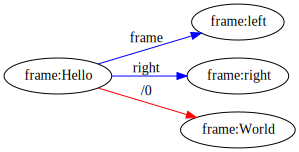

In [7]:
hello = Frame('Hello')
world = hello // Frame('World') << Frame('left') >> Frame('right')
print(world)
world.plot()

### Stack operations

`nest[]` part of the `Frame` object can work both as vector and stack, so to manipulate with this stack we need to define a set of methods, will be used later in the FORTH-like language demo.

Stack effect if comments were taken from FORTH: `( before -- after )`
* stack state is written in `( parens )`
* `before` is a top of stack state, the rightmost element is the top element on the stack
* `after` part shows stack state after some function/word execution
* the optional element after `->` shows return value from the Python method
  * if there is no `->` method returns the object itself which contains a modified stack

In [20]:
class Frame(Frame):

    # ( 1 2 3 -- 1 2 3 ) -> 3
    def top(self): return self.nest[-1]
    # ( 1 2 3 -- 1 2 3 ) -> 2
    def tip(self): return self.nest[-2]
    # ( 1 2 3 -- 1 2 ) -> 3
    def pop(self): return self.nest.pop(-1)
    # ( 1 2 3 -- 1 3 ) -> 2
    def pip(self): return self.nest.pop(-2)

    # ( 1 2 3 -- 1 2 3 3 )
    def dup(self): return self // self.top()
    # ( 1 2 3 -- 1 2 )
    def drop(self): self.pop(); return self
    # ( 1 2 3 -- 1 3 2 )
    def swap(self): return self // self.pip()
    # ( 1 2 3 -- 1 2 3 2 )
    def over(self): return self // self.tip()
    # ( 1 2 3 -- 1 3 )
    def press(self): self.pip(); return self
    # ( 1 2 3 -- )
    def dot(self): self.nest = []; return self

## Meta

In [9]:
class Meta(Frame): pass

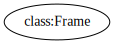

In [10]:
class Class(Meta): pass

frame = Class('Frame')
frame.plot()

## Primitive types

Primitive types can be implemented at a low level close to machine hardware, or language primitives, runtime, and core library from the viewpoint of the implementation (target) language in code synthesis.

In [11]:
prim = Class('Primitive') ; prim['super'] = frame
symbol = Class('Symbol') ; prim // symbol
string = Class('String') ; prim // string
number = Class('Number') ; prim // number
number // ( Class('Integer') // Class('Hex') // Class('Bin') )
prim.plot(file='img/prim.png')

In [12]:
class Primitive(Frame): pass
class Symbol(Primitive): pass
class String(Primitive): pass

In [13]:
class Number(Primitive):
    def __init__(self, V): Primitive.__init__(self, float(V))

Number('+012.340')


<number:12.34>

In [14]:
class Integer(Number):
    def __init__(self, V): Primitive.__init__(self, int(V))

Integer('+01234')


<integer:1234>

In [15]:
class Hex(Integer):
    def __init__(self, V): Primitive.__init__(self, int(V[2:], 0x10))
    def _val(self): return hex(self.val)

Hex('0xDeadBeef')


<hex:0xdeadbeef>

In [16]:
class Bin(Integer):
    def __init__(self, V): Primitive.__init__(self, int(V[2:], 0x02))
    def _val(self): return bin(self.val)

Bin('0b1101')


<bin:0b1101>

## Stack Machine Interpreter (FORTH)

* [starting] https://www.forth.com/starting-forth/

The Forth programming language is well known as the simplest programming language that can ever be from the viewpoint of the implementation (not programming in it). While you are reading some manual on it such as [starting] or [kelly] you have a feel of understanding how it works inside in case you already have any experience in programming.

Forth is not intended to be used as a general-purpose language, it is ugly in this role (see disadvantages later). But, due to its internal simplicity, it stays unbeatable as a command interpreter (CLI shell) and config file parser/interpreter. One of the best usages is using FORTH as a command interface on microcontroller-based devices works over the UART serial port. The language was first designed as a macro system for direct low-level programming of radiotelescope hardware in place of assembler. Its design was great at that moment, having few kilobytes of RAM in a system, provides interactive and programmable command shell. And it still stays good for this narrow use case.

What makes Forth unusable, and should be avoided if possible in our sample demo:
* **direct byte-level memory addressing**<br>most implementations use a single writable memory area which contains both machine/threaded code and data; any error in a program can write random executable code which guarantees system fault (in the best case) and unpredictable data corrupt<br>this biggest problem can be fixed by using symbolic `.slot{}` names in place of random integer addresses
* **lack of any data types**<br>besides integers, bytes, and byte-counted strings, there are no floating-point numbers (optional!), and any other data structures must be programmed at a machine level<br>using `Frame`-based objects will save us from this hell
* **Forth is no-syntax language**<br>any group of non-space characters is a legal Forth command (word) name or integer number; interpreter parses these groups one by one and executes it in place every time it sees next word name<br>factically, *it is not a problem but the most advantage of Forth*: parser is extra simple and need only dozen machine commands to work
* **postfix notation**<br>it's a primary huge problem which makes source code unreadable; while Forth executes commands (words) one by one, there is no way to code things like math statements in a readable form, all code is full of stack fluffing and memory byte banging
* **lack of libraries and compatibility between different systems**<br>It's a tradition that every Forth programmer writes his own Forth system incompatible with every other. So, not a surprise that incompatibility makes writing libraries a questionable thing. Most popular systems with big communities have a chance to have common libraries, but it's level so low that most times it is better to write your own yet another Forth in C then using assembly and direct .dll calls. Here we have Python with batteries included.

We'll not avoid postfix no-syntax and stack manipulations: our goal here to show how you can brew your own programming language in a few hours (maybe in assembly). To do it the system must be cutted down to the most simple shape:
* extra simple parser (lexer only), 
* **stack** for data in `.nest[]`, and 
* global single **vocabulary** in `.slot{}` for variables and command definitions.

Easy to guess and fun to mess that any Frame-inherited object can act as a Forth Virtual Machine (FVM): any object graph element has its own stack and vocabulary hardcoded into the base node class. Moreover, computations on a stack when you push data, run operations on top elements, and pop results are so fundamental in compiler/interpreter programming and computer language design, as all mainstream languages such as Java, C#, and Python uses this stack architecture almost in every VM internals.

### Active (Executable) Data

We'll introduce the special subset of data types which has an ability to be executed. **Execution** is the fundamental entity described by lambda calculus, which is also unsplittable from the next concept -- **execution context** `ctx` which holds the state between every elementary computation step. Not a surprise that context must include as a minimum both **environment** (vocabulary) and **stack**.

In [17]:
# executable data
class Active(Frame): pass
# [FORTH] Virtual Machine
class VM(Active): pass

In [18]:
vm = VM('FORTH') ; vm << vm


<vm:FORTH>
	vm = <vm:FORTH> _/

In [19]:
# wrapper class for Python functions
class Command(Active):
    def __init__(self,F):
        Active.__init__(self,F.__name__)
        self.fn = F # wrap
    def eval(self,ctx):
        return self.fn(ctx) # run wrapped

def BYE(ctx): sys.exit(0)
vm >> Command(BYE)


<vm:FORTH>
	vm = <vm:FORTH> _/
	BYE = <command:BYE>

## metaL: [meta]programming [L]anguage

The `metaL` is not about the syntax of programs written in plain text files such as used by most traditional programming languages. In a reverse, It is an experimental concept of a programming language without language syntax, files, and parsing. The idea was:

* Is it possible and a handful to implement a programming system that directly uses some data structure in memory as a program specification, without any source code in plain text files?
* What effects and impact on programming habits will be in case of programs able to be modified in runtime by itself and maybe by a user? Will the real metaprogramming be a powerful magic weapon able to beat C++ and Java in their fatherlands, or it will introduce a lot of errors and problems?
* Can the parsing stage which presents practically in any programming language compiler/interpreter be totally avoided? This can be done by using your host language (Python, Java,..) to create a program graph in memory in runtime, or at a compile stage. But how painless will be the use of language was not especially targetted on graph construction and manipulations?
* Is concept programming idea alive? What are changes if we mix the system's code, specification, and documentation in a single active knowledge graph, and use the knowledge but not source code for software design?

metaL not a language with its own syntax, but a set of principles for homoiconic and symbolic programming system design. It is provided as a tutorial with step by step understanding and implementation of universal runtime, which contains elements of procedural, functional, logic, message passing, data flow, and any other programming. If you want some feature, you should be able to add it itself, or with a help of the open community.

### Syntax-based data input

* What will happens if we allow the user to specify his own arbitrary programming language syntax he wants to use?

Program specification in plain text source code still here dozens of years, as it showed itself as a good enough practice. Even if we move to alternative programming, storing data in human-readable ASCII files is known as the best approach for cross-system exchange. If we want to have the ability to use any syntax for programming or data input, we should find a powerful method to do it.

You can found this manual too highly biased to interpreters and compilers programming. It is not only because of pitching the [secret weapon](http://www.paulgraham.com/avg.html) but compiler programming is widely known as a complex enough area that uses multiple state machine types and graph-like data structures as its main methods.

* typical compiler scheme

![](img/compiler.png)

## Hierarchical State Machines

* [Бесконечные возможности конечных автоматов | Введение в "eco-programming"](https://www.youtube.com/watch?v=6xzn78onzQk) /video/
* [psicc2] Book on using HSM approach for embedded reactive software development by Miro Samek

## Graph Matching and Transformations

Some ideas about the power of pattern matching and declarative programming via graph transformations:
* Professor Richard J. Gaylord's<br>**Wolfram Language Fundamentals** 
  * [Part One](https://www.youtube.com/watch?v=H-rnezxOCA8) /video/

## Distributed Programming

* parallelization
* distribution
* computation balancing

### DataFlow programming

* Marvin Humphrey **Dataflow Programming** /[video](https://www.youtube.com/watch?v=aPh4Z3SioB8)/
  * Wesley M. Johnston, J.R. Paul Hanna, Richard J. Millar<br>**Advances in Dataflow Programming Languages** [pdf](http://www.cs.ucf.edu/~dcm/Teaching/COT4810-Spring2011/Literature/DataFlowProgrammingLanguages.pdf)
* [lucid] William W. Wadge **Lucid, the dataflow programming language**

### Async Messaging: Actor model

* Hewitt, Meijer and Szyperski: **The Actor Model (everything you wanted to know...)** /[video](https://www.youtube.com/watch?v=7erJ1DV_Tlo)/

## Type Systems

In programming languages, a **type system** is a *logical system* built upon a set of rules that assigns a property called a type (class) to the various constructs of a computer program or parts of an object graph in our case. The use of this type system formalism enforces the correct application of categories the programmer uses for building algebraic data types, data structures, and other components assembled from elements available in a system (for example it forces the correct combinations of such elements as String, Vector of Numbers, Function returns Bool, etc). The *main purpose of a type system* is to **reduce bugs** in a computer system specification by defining interfaces and relations between different parts of a system, and then checking that all these parts were connected in a consistent way. 

The importance of type checker (can be included as an optional part or external tool) in a software development system is preventing a lot of errors in executable specifications and data combining before these executable data will be run. For a generic application programming methods of type control can be very useful for such tasks as a business process description, and arbitrary data transformations.

* https://en.wikipedia.org/wiki/Type_system
* https://www.youtube.com/watch?v=gTrU_BxWH7c
* https://www.youtube.com/watch?v=hy1wjkcIBCU

## Automated Code Generation

Compiling application graph models into static code for embedded systems.

* https://wiki.c2.com/?AutomatedCodeGeneration

Target systems:
* ARM Cortex-M (most wide and used microcontrollers family)
* embedded Linux (mostly Web hosting variant + home routers)

Target language candidates:
* ANSI C (embedded dialects)<br>required to be compatible with most development teams
* Rust<br>perspective language with rigid type system good for error checking
* LLVM IR (most low-level)<br>can be good for narrow tasks like parsers and tiny computation blocks
* Python<br>metacircular graph engine (re)implementation

## Android

The most widely used mobile platform is Android:
* low-price devices
* no-cost development tools and deployment

Disadvantages:
- requires native Java & NDK development, or
- requires special tools and methods to port from Python/Web to mobile Web app able to run in offline

- **Native Java & NDK**: full control of the device, any service available without any problems.
- *PhoneGap*s build a bridge between Web and mobile platform using mobile browser or WebView OS component and a lot of intermediate library layers: slow, memory/RAM hungry, especially slow start, a lot of dependences
  - Cordova
  - PWA: Progressive Web App
  - React Native

## Metacircular Implementation

*Metacircular implementation* of a programming language means that it is *implemented in itself*. In the case of the interpreter, it also can mean that the **guest language** works *using the runtime* of a **host language**, and it is easier to write a whole system.

In books for many programming languages with names like "The Language and its implementation", it is a common case to describe semantics or even tiny implementation of a described language. This like section presents in a manual combines many goals:
* shows a real usage of a language used for relatively complex task such as interpreter/compiler coding
* describes many details of internal mechanics and the language semantics
* test interpreter/compiler over a set of complex source code of itself
* demonstrates the advantages and misses of the language such as syntax readability, expressiveness, flexibility, use of core libraries, etc.

Since we describe the system which targets on replacement of general-purpose languages, it is a good practice to include a special section with the metacircular implementation of the system to show its advantages over classical ways of software development.

Providing ready to use metasystem in a bundle with this manual can also be a workaround about copyright laws and license limitations, as you can use it to brew your own derived system not covered by restrictions. Thus this work goes under OpenSource license to protect described technology from the [Smalltalk price-induced death](http://wiki.c2.com/?WhyIsSmalltalkDead) and commercial capture, but you can reimplement it for your own needs.

## References

[minsky] Marvin Minsky **Frames for data representation** [html](https://web.media.mit.edu/~minsky/papers/Frames/frames.html)

[tyugu] Э.Х.Тыугу **Концептуальное программирование**. М.: Наука, 1984. 255 с [djvu](https://github.com/ponyatov/OGP/releases/download/260420-5d5e/ConceptProg.ru.djvu)

[sym88] J. Symbolic Computation (1988) 5, 359-375\ **The Programming System PRIZ**<br>\ G.Mints, E.Tyugu, Institute of Cybernetics, Estonian Academy of Sciences,Tallinn 200108, USSR \ [pdf](https://www.academia.edu/18315153/The_programming_system_PRIZ?auto=download)

[priz] **Инструментальная система программирования ЕС ЭВМ (ПРИЗ)** / М.И. Кахро, А.П. Калья, Энн Харальдович Тыугу . – Изд. 2-е – Москва : Финансы и статистика, 1988 . – 181 с ISBN 5-279-00111-2 [pdf](https://github.com/ponyatov/OGP/releases/download/260420-5d5e/PRIZ.ru.pdf)

[starting] Leo Brodie **Starting FORTH** [html](https://www.forth.com/starting-forth/)

[kelly] M.G.Kelly, N.Spies **Forth - A Text and Reference** [amazon](https://www.amazon.com/Forth-Text-Reference-Prentice-Hall-Software/dp/0133263312) | [ru.djvu](https://github.com/ponyatov/OGP/releases/download/260420-5d5e/KellySpies.ru.djvu)

[cactus] http://www.forth.org.ru/~cactus/library.htm (ru)

[psicc2] Miro Samek **Practical UML Statecharts in C/C++**, 2nd Edition:
Event-Driven Programming for Embedded Systems [html](https://www.state-machine.com/psicc2/) | [pdf](https://sourceforge.net/projects/qpc/files/doc/PSiCC2.pdf)

[lucid] William W. Wadge **Lucid, the dataflow programming language**

[pierce] Benjamin C. Pierce **Types and Programming Languages**

[pierceru] Пирс Бенджамин **Типы в языках программирования** /[ozon](https://www.ozon.ru/context/detail/id/7410082/)/